Support Vector Machine

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def load_and_preprocess_data(filepath='/Users/pranayjain/University of Freiburg/4th Semster/Psycology Project/python_scripts/output_directory/evaluation_dataset/hurst_evaluation/ho_slope_1byf_all.csv'):
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Convert 'sleep_stage' to binary for the first level classification: Wake (0) vs Sleep (1,2,3)
    df['binary_sleep_stage'] = df['sleep_stage'].apply(lambda x: 0 if (x.split()[0] == 'W') else 1)
    df['sleep_stage'] = df['sleep_stage'].apply(lambda x: 0 if (x.split()[0] == 'W') else x.split()[0])
    df.replace(["unscorable","Unscorable"],"-1",inplace=True)

    # Encode 'state' to numeric values for the second level classification
    state_encoder = LabelEncoder()
    df['encoded_state'] = state_encoder.fit_transform(df['state'])
    
    # Features and labels for first level classification
    X = df[df.columns[5:]]
    y_level1 = df['binary_sleep_stage']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_level1, df['encoded_state'], df['sleep_stage'], state_encoder, scaler

def split_data(X, y):
    # Split the data into training and testing sets
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Adjust the formatting issue here
    fmt = 'd'  # Use 'd' for integers, as confusion matrix should be integer counts
    thresh = cm.max() / 2.  # threshold for text color contrast
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Now, use this function in your evaluate_and_plot to handle the visualization:
def evaluate_and_plot(model, X_test, y_test, class_names):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.2f}")
    plt.figure(figsize=(10, 7))
    plot_confusion_matrix(cm, classes=class_names)
    plt.show()


Accuracy: 0.96


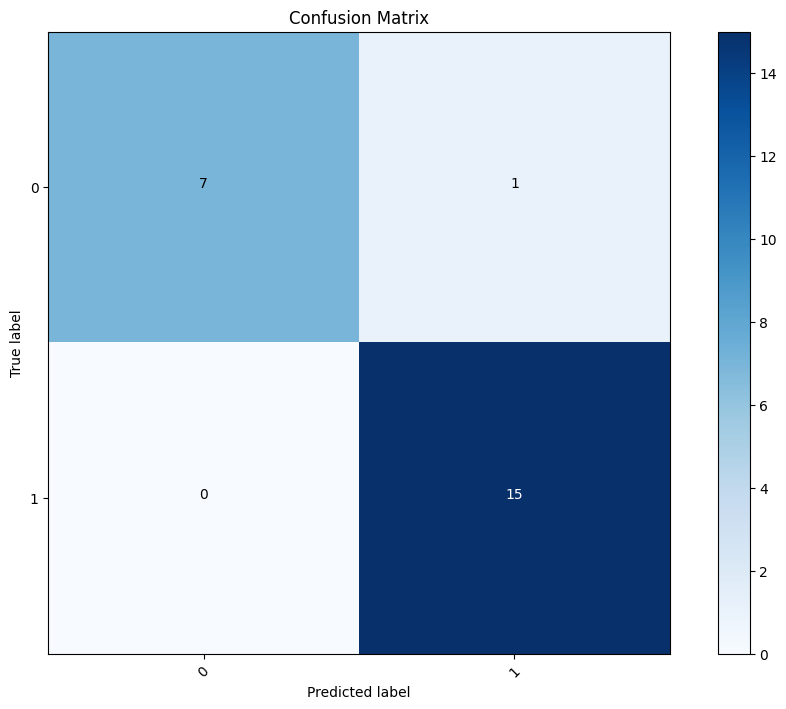

In [13]:
def train_svm(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    model = SVC(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return predictions

def filter_data_based_on_predictions(X, predictions, target):
    # Filter data based on predictions
    filtered_indices = np.where(predictions == target)[0]
    return filtered_indices


X_scaled, y_level1, encoded_state, sleep_stage, state_encoder, scaler = load_and_preprocess_data()

# Split the data for training and testing without assuming the true labels for filtering
X_train, X_test, y_train_level1, y_test_level1 = split_data(X_scaled, y_level1)

# Level 1: Wake vs. Sleep classification
model_level1 = train_svm(X_train, y_train_level1)
predictions_level1 = evaluate_model(model_level1, X_test, y_test_level1)
evaluate_and_plot(model_level1, X_test, y_test_level1, model_level1.classes_)

Accuracy: 0.88


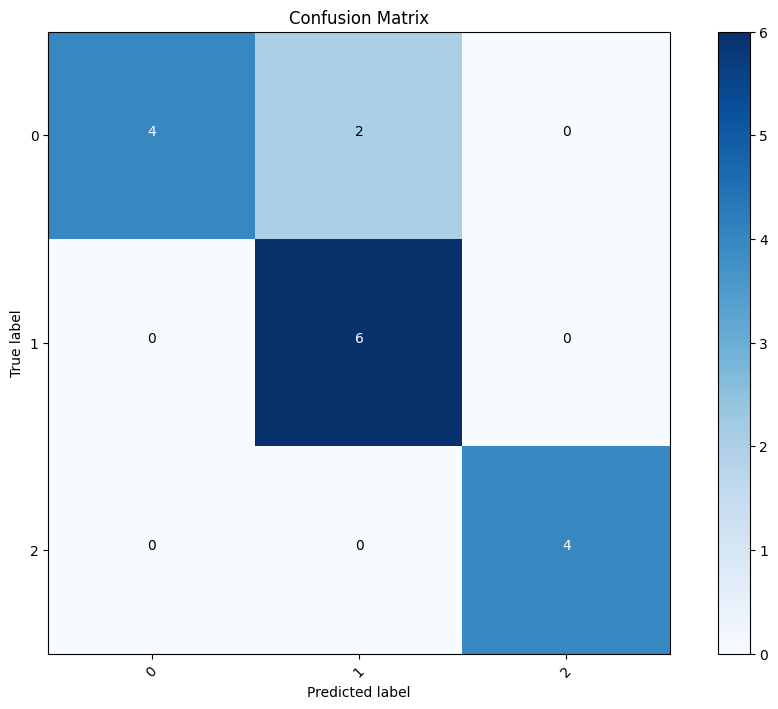

In [14]:
# # Dynamic filtering for Level 2 classification based on Level 1 predictions
# wake_filtered_indices = filter_data_based_on_predictions(X_test, predictions_level1, 0)  # Filter for Wake predictions
# X_test_wake = X_test[wake_filtered_indices]
# if len(X_test_wake) > 0:
#     # Assuming we have a way to align these filtered X_test_wake instances with their original 'state' labels
#     # For true dynamic prediction, you would need the corresponding states for these instances
#     y_test_state = encoded_state[wake_filtered_indices]  # Placeholder for demonstration
#     model_level2 = train_svm(X_test_wake, y_test_state)
#     predictions_level2 = evaluate_model(model_level2, X_test_wake, y_test_state)

# evaluate_and_plot(model_level2, X_test_wake, y_test_state, model_level2.classes_)

# Similarly, dynamic filtering for Level 3 classification based on Level 1 being Sleep
sleep_filtered_indices = filter_data_based_on_predictions(X_test, predictions_level1, 1)  # Filter for Sleep predictions
X_test_sleep = X_test[sleep_filtered_indices]
if len(X_test_sleep) > 0:
    # Again, aligning filtered instances with their original 'sleep_stage' labels for demonstration
    y_test_sleep_stage = sleep_stage[sleep_filtered_indices].astype(int)  # Placeholder for demonstration
    model_level3 = train_svm(X_test_sleep, y_test_sleep_stage)
    predictions_level3 = evaluate_model(model_level3, X_test_sleep, y_test_sleep_stage)


evaluate_and_plot(model_level3, X_test_sleep, y_test_sleep_stage, model_level3.classes_)

Accuracy: 0.74


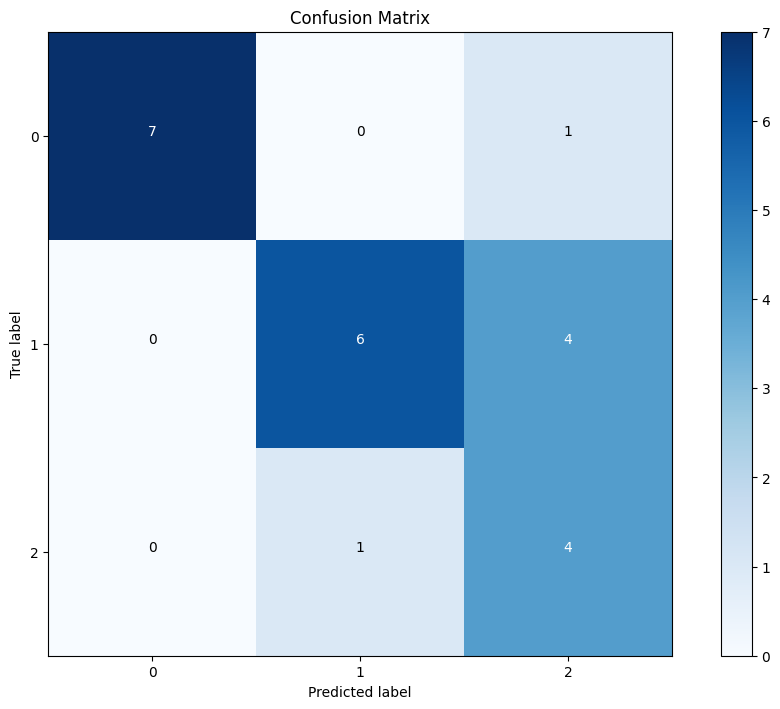

In [22]:
X_scaled, y_level1, encoded_state, sleep_stage, state_encoder, scaler = load_and_preprocess_data()

# Split the data for training and testing without assuming the true labels for filtering
X_train, X_test, y_train_level1, y_test_level1 = split_data(X_scaled, sleep_stage.astype(int))

# Level 1: Wake vs. Sleep classification
model_level1 = train_svm(X_train, y_train_level1)
predictions_level1 = evaluate_model(model_level1, X_test, y_test_level1)
evaluate_and_plot(model_level1, X_test, y_test_level1, model_level1.classes_[0:3])